# Metrics for training + validation

In [ ]:
#y_true = y_test
#y_pred = test_preds
#def dice_coef(y_true, y_pred, smooth=1):
#    y_true_f = K.flatten(y_true)
#    y_pred_f = K.flatten(y_pred)
#    intersection = K.sum(y_true_f * y_pred_f)
#    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


#def dice_coef_loss(y_true, y_pred):
#    return -dice_coef(y_true, y_pred)


#hi = y_test / 255
#hi = K.flatten(hi)
#hi = tf.convert_to_tensor(hi, dtype=None)
#pred = test_preds
#pred = K.flatten(pred)
#pred = tf.convert_to_tensor(test_preds, dtype=None)

def dice_coef(a, b):
          #  hi = K.hi
          #  hi = hi / 255
    
          #    hi = tf.convert_to_tensor(hi, dtype=None)
          #    pred = tf.convert_to_tensor(test_preds, dtype=None)
    hi = a
  #  hi = tf.dtypes.cast(hi, tf.float32)
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    upper_part = 2 * K.sum((hi * pred))
    lower_part = K.sum(hi + pred)
    dice = upper_part / lower_part
    return dice

def dice_coef_loss(a, b):
    loss = 1 - dice_coef(a, b)
    return loss

def jaccard_index(a, b):
    hi = a 
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    numerator = K.sum(hi * pred)
    denominator = K.sum((hi + pred) - (hi * pred))
    iou = numerator / denominator
    return iou

# Libraries

In [ ]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# U-net

In [ ]:
inputs = Input((row, columns, 3))

s = Lambda(lambda x: x/255) (inputs)

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(3, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.5,
    staircase=True)
    
opt = keras.optimizers.Adam(learning_rate=0.001)

#model.compile(optimizer='adam', loss='binary_crossentropy')
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[dice_coef, jaccard_index])

model.summary()

# Training

In [ ]:
print(x_train.shape)
print(y_train.shape)
filepath = "./model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min' )
#mode='min'
callbacks_list = [earlystopper, checkpoint]

history = model.fit(total_x_train, total_y_train, validation_split=0.2, batch_size=1, epochs=20, callbacks=callbacks_list)



Epoch 1/20
31/32 [============================>.] - ETA: 0s - loss: 0.5795 - dice_coef: 0.3774 - jaccard_index: 0.2347
Epoch 00001: val_loss improved from inf to 0.55603, saving model to ./model.h5
32/32 [==============================] - 1s 42ms/step - loss: 0.5754 - dice_coef: 0.3751 - jaccard_index: 0.2330 - val_loss: 0.5560 - val_dice_coef: 0.3899 - val_jaccard_index: 0.2443
Epoch 2/20
31/32 [============================>.] - ETA: 0s - loss: 0.4589 - dice_coef: 0.4589 - jaccard_index: 0.3047
Epoch 00002: val_loss improved from 0.55603 to 0.44988, saving model to ./model.h5
32/32 [==============================] - 1s 31ms/step - loss: 0.4599 - dice_coef: 0.4496 - jaccard_index: 0.2979 - val_loss: 0.4499 - val_dice_coef: 0.5619 - val_jaccard_index: 0.4121
Epoch 3/20
31/32 [============================>.] - ETA: 0s - loss: 0.3710 - dice_coef: 0.6069 - jaccard_index: 0.4616
Epoch 00003: val_loss improved from 0.44988 to 0.42059, saving model to ./model.h5
32/32 [==============================] - 1s 31ms/step - loss: 0.3683 - dice_coef: 0.6097 - jaccard_index: 0.4639 - val_loss: 0.4206 - val_dice_coef: 0.5391 - val_jaccard_index: 0.3769
Epoch 4/20
32/32 [==============================] - ETA: 0s - loss: 0.3714 - dice_coef: 0.6110 - jaccard_index: 0.4613
Epoch 00004: val_loss improved from 0.42059 to 0.33885, saving model to ./model.h5
32/32 [==============================] - 1s 34ms/step - loss: 0.3714 - dice_coef: 0.6110 - jaccard_index: 0.4613 - val_loss: 0.3389 - val_dice_coef: 0.6689 - val_jaccard_index: 0.5232
Epoch 5/20
30/32 [===========================>..] - ETA: 0s - loss: 0.2669 - dice_coef: 0.7160 - jaccard_index: 0.5828
Epoch 00005: val_loss improved from 0.33885 to 0.28395, saving model to ./model.h5
32/32 [==============================] - 1s 31ms/step - loss: 0.2700 - dice_coef: 0.7058 - jaccard_index: 0.5740 - val_loss: 0.2840 - val_dice_coef: 0.7550 - val_jaccard_index: 0.6248
Epoch 6/20
31/32 [============================>.] - ETA: 0s - loss: 0.2487 - dice_coef: 0.7622 - jaccard_index: 0.6405
Epoch 00006: val_loss did not improve from 0.28395
32/32 [==============================] - 1s 25ms/step - loss: 0.2523 - dice_coef: 0.7515 - jaccard_index: 0.6288 - val_loss: 0.2910 - val_dice_coef: 0.7372 - val_jaccard_index: 0.6011
Epoch 7/20
31/32 [============================>.] - ETA: 0s - loss: 0.2505 - dice_coef: 0.7494 - jaccard_index: 0.6223
Epoch 00007: val_loss improved from 0.28395 to 0.23532, saving model to ./model.h5
32/32 [==============================] - 1s 31ms/step - loss: 0.2512 - dice_coef: 0.7408 - jaccard_index: 0.6125 - val_loss: 0.2353 - val_dice_coef: 0.7911 - val_jaccard_index: 0.6636
Epoch 8/20
31/32 [============================>.] - ETA: 0s - loss: 0.2196 - dice_coef: 0.7909 - jaccard_index: 0.6758
Epoch 00008: val_loss did not improve from 0.23532
32/32 [==============================] - 1s 25ms/step - loss: 0.2253 - dice_coef: 0.7837 - jaccard_index: 0.6668 - val_loss: 0.2435 - val_dice_coef: 0.7647 - val_jaccard_index: 0.6282
Epoch 9/20
30/32 [===========================>..] - ETA: 0s - loss: 0.2429 - dice_coef: 0.7676 - jaccard_index: 0.6429
Epoch 00009: val_loss did not improve from 0.23532
32/32 [==============================] - 1s 25ms/step - loss: 0.2515 - dice_coef: 0.7586 - jaccard_index: 0.6311 - val_loss: 0.2954 - val_dice_coef: 0.7596 - val_jaccard_index: 0.6266
Epoch 10/20
31/32 [============================>.] - ETA: 0s - loss: 0.2105 - dice_coef: 0.7990 - jaccard_index: 0.6829
Epoch 00010: val_loss improved from 0.23532 to 0.21140, saving model to ./model.h5
32/32 [==============================] - 1s 30ms/step - loss: 0.2243 - dice_coef: 0.7933 - jaccard_index: 0.6756 - val_loss: 0.2114 - val_dice_coef: 0.8183 - val_jaccard_index: 0.6987
Epoch 11/20
31/32 [============================>.] - ETA: 0s - loss: 0.1997 - dice_coef: 0.8043 - jaccard_index: 0.6862
Epoch 00011: val_loss improved from 0.21140 to 0.20794, saving model to ./model.h5
32/32 [==============================] - 1s 30ms/step - loss: 0.1984 - dice_coef: 0.8067 - jaccard_index: 0.6895 - val_loss: 0.2079 - val_dice_coef: 0.8330 - val_jaccard_index: 0.7194
Epoch 12/20
31/32 [============================>.] - ETA: 0s - loss: 0.1806 - dice_coef: 0.8329 - jaccard_index: 0.7230
Epoch 00012: val_loss improved from 0.20794 to 0.20329, saving model to ./model.h5
32/32 [==============================] - 1s 30ms/step - loss: 0.1797 - dice_coef: 0.8346 - jaccard_index: 0.7252 - val_loss: 0.2033 - val_dice_coef: 0.8401 - val_jaccard_index: 0.7277
Epoch 13/20
30/32 [===========================>..] - ETA: 0s - loss: 0.1493 - dice_coef: 0.8643 - jaccard_index: 0.7666
Epoch 00013: val_loss improved from 0.20329 to 0.18351, saving model to ./model.h5
32/32 [==============================] - 1s 31ms/step - loss: 0.1480 - dice_coef: 0.8662 - jaccard_index: 0.7692 - val_loss: 0.1835 - val_dice_coef: 0.8615 - val_jaccard_index: 0.7598
Epoch 14/20
31/32 [============================>.] - ETA: 0s - loss: 0.1532 - dice_coef: 0.8643 - jaccard_index: 0.7674
Epoch 00014: val_loss did not improve from 0.18351
32/32 [==============================] - 1s 25ms/step - loss: 0.1518 - dice_coef: 0.8656 - jaccard_index: 0.7693 - val_loss: 0.2011 - val_dice_coef: 0.8497 - val_jaccard_index: 0.7419
Epoch 15/20
31/32 [============================>.] - ETA: 0s - loss: 0.1331 - dice_coef: 0.8772 - jaccard_index: 0.7850
Epoch 00015: val_loss did not improve from 0.18351
32/32 [==============================] - 1s 25ms/step - loss: 0.1358 - dice_coef: 0.8777 - jaccard_index: 0.7858 - val_loss: 0.1877 - val_dice_coef: 0.8482 - val_jaccard_index: 0.7409
Epoch 16/20
32/32 [==============================] - ETA: 0s - loss: 0.1324 - dice_coef: 0.8815 - jaccard_index: 0.7925
Epoch 00016: val_loss improved from 0.18351 to 0.16742, saving model to ./model.h5
32/32 [==============================] - 1s 32ms/step - loss: 0.1324 - dice_coef: 0.8815 - jaccard_index: 0.7925 - val_loss: 0.1674 - val_dice_coef: 0.8705 - val_jaccard_index: 0.7719
Epoch 17/20
31/32 [============================>.] - ETA: 0s - loss: 0.1294 - dice_coef: 0.8799 - jaccard_index: 0.7892
Epoch 00017: val_loss improved from 0.16742 to 0.15640, saving model to ./model.h5
32/32 [==============================] - 1s 30ms/step - loss: 0.1282 - dice_coef: 0.8809 - jaccard_index: 0.7907 - val_loss: 0.1564 - val_dice_coef: 0.8782 - val_jaccard_index: 0.7839
Epoch 18/20
31/32 [============================>.] - ETA: 0s - loss: 0.1236 - dice_coef: 0.8882 - jaccard_index: 0.8019
Epoch 00018: val_loss did not improve from 0.15640
32/32 [==============================] - 1s 25ms/step - loss: 0.1225 - dice_coef: 0.8890 - jaccard_index: 0.8030 - val_loss: 0.1624 - val_dice_coef: 0.8700 - val_jaccard_index: 0.7716
Epoch 19/20
31/32 [============================>.] - ETA: 0s - loss: 0.1147 - dice_coef: 0.8988 - jaccard_index: 0.8175
Epoch 00019: val_loss improved from 0.15640 to 0.15228, saving model to ./model.h5
32/32 [==============================] - 1s 30ms/step - loss: 0.1146 - dice_coef: 0.8982 - jaccard_index: 0.8164 - val_loss: 0.1523 - val_dice_coef: 0.9007 - val_jaccard_index: 0.8198
Epoch 20/20
30/32 [===========================>..] - ETA: 0s - loss: 0.1254 - dice_coef: 0.8866 - jaccard_index: 0.7985
Epoch 00020: val_loss improved from 0.15228 to 0.15115, saving model to ./model.h5
32/32 [==============================] - 1s 30ms/step - loss: 0.1226 - dice_coef: 0.8879 - jaccard_index: 0.8005 - val_loss: 0.1511 - val_dice_coef: 0.8763 - val_jaccard_index: 0.7824

# Plotting history

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

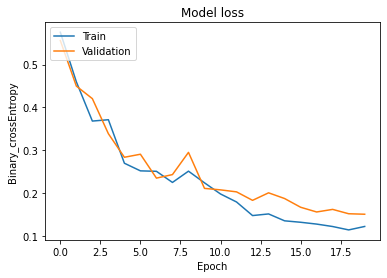

In [ ]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice coeff')
plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

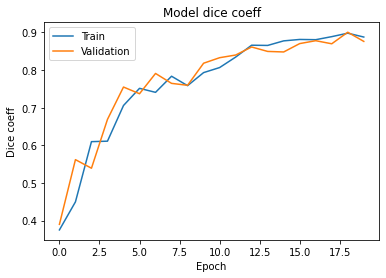

In [ ]:
plt.plot(history.history['jaccard_index'])
plt.plot(history.history['val_jaccard_index'])
plt.title('Model jaccard index')
plt.ylabel('Jaccard index')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

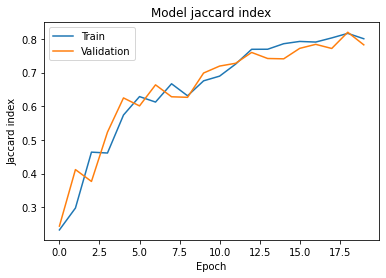